## Project Introduction: Predicting Late Delivery Risk in Supply Chain Management

In today's competitive e-commerce and logistics environment, timely delivery is essential to maintaining customer satisfaction and optimizing supply chain efficiency. Late deliveries can negatively impact customer loyalty, increase operational costs, and lead to penalties or loss of business opportunities. For businesses with large-scale operations, the ability to predict and mitigate late deliveries becomes crucial.

This project aims to tackle the problem of predicting late deliveries using advanced machine learning techniques. By leveraging a real-world supply chain dataset, we built multiple models to accurately identify orders at risk of late delivery. Our approach not only focuses on achieving high prediction accuracy but also on minimizing false negatives (where late deliveries are missed), ensuring that no critical late deliveries go undetected.

The dataset used in this project contains a wide range of features, including order details, product information, customer data, shipping dates, and payment types. We explored the relationships between these variables to uncover key patterns that impact delivery times. Through feature engineering, statistical analysis, and machine learning model training, we sought to gain actionable insights into the factors driving late deliveries.

In this study, we experimented with Logistic Regression, Random Forest, and XGBoost models, utilizing feature selection techniques such as Recursive Feature Elimination (RFE) to focus on the most relevant predictors. Our key objective was to provide the business with a robust solution that not only forecasts late deliveries but also enables proactive measures to ensure timely shipments.

In [515]:
import pandas as pd

data = pd.read_csv("DataCoSupplyChainDataset.csv", encoding='ISO-8859-1')  # or encoding='latin1'
data.head()


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [516]:
data.shape

(180519, 53)

The total data set consists of 180519 records and 53 columns

In [517]:
data["Late_delivery_risk"].value_counts(normalize = True)*100

Late_delivery_risk
1    54.829132
0    45.170868
Name: proportion, dtype: float64

## 1. EXPLORATORY DATA ANALYSIS

In [518]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

**SALES PER DELIVERY STATUS:**

In [519]:
sales_per_delivery_status = data.groupby('Delivery Status')['Sales'].sum()
sales_per_delivery_status

Delivery Status
Advance shipping     8.518008e+06
Late delivery        2.012640e+07
Shipping canceled    1.570305e+06
Shipping on time     6.570026e+06
Name: Sales, dtype: float64

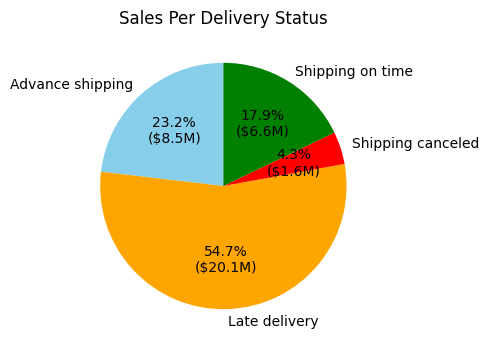

In [520]:
color_mapping = {
    'Shipping canceled': 'red', 
    'Shipping on time': 'green', 
    'Late delivery': 'orange', 
    'Advance shipping': '#87CEEB'
}



colors = [color_mapping.get(status, 'gray') for status in sales_per_delivery_status.index]


def format_autopct(pct, all_values):
    absolute = int(pct/100.*sum(all_values))
    return f'{pct:.1f}%\n(${absolute/1e6:.1f}M)'


plt.figure(figsize=(6, 4))
sales_per_delivery_status.plot(
    kind='pie', 
    autopct=lambda pct: format_autopct(pct, sales_per_delivery_status), 
    startangle=90, 
    colors=colors
)
plt.title('Sales Per Delivery Status')
plt.ylabel('')  
plt.show()

This pie chart shows the breakdown of sales based on delivery status. The majority of sales (54.7%) come from orders with late delivery, indicating a significant operational issue that could impact customer satisfaction. Orders with advance shipping make up 23.2% of sales, showing some operational efficiency, while on-time deliveries account for 17.9%. Canceled shipments represent 4.3% of sales, suggesting potential revenue loss. The dominance of late deliveries suggests that improving delivery times could enhance customer satisfaction and reduce operational risks.

**SALES PER MARKET:**

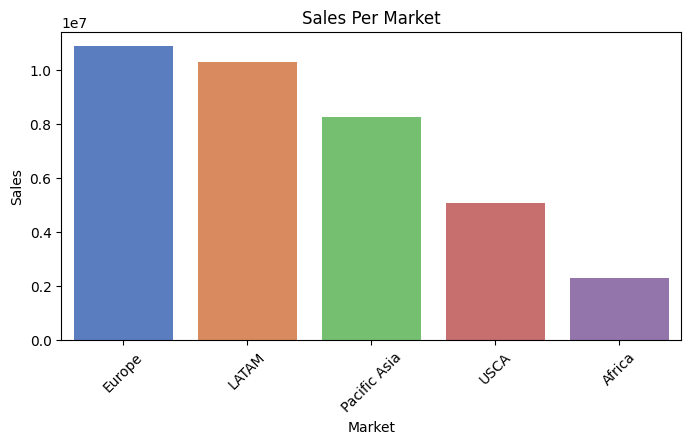

In [521]:
sales_per_market = data.groupby('Market')['Sales'].sum().sort_values(ascending=False)


plt.figure(figsize=(8, 4))
sns.barplot(x=sales_per_market.index, y=sales_per_market.values, palette='muted')
plt.title('Sales Per Market')
plt.xlabel('Market')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()


Europe leads in sales, contributing the most, followed closely by LATAM. Pacific Asia also shows a significant share of sales but lags behind Europe and LATAM. USCA comes in lower, and Africa shows the smallest sales contribution among the markets. The clear gap between these regions indicates potential differences in market size, customer base, or delivery performance across these geographic areas. 

**TOP 10 SALES PER PRODUCT CATEGORY:**

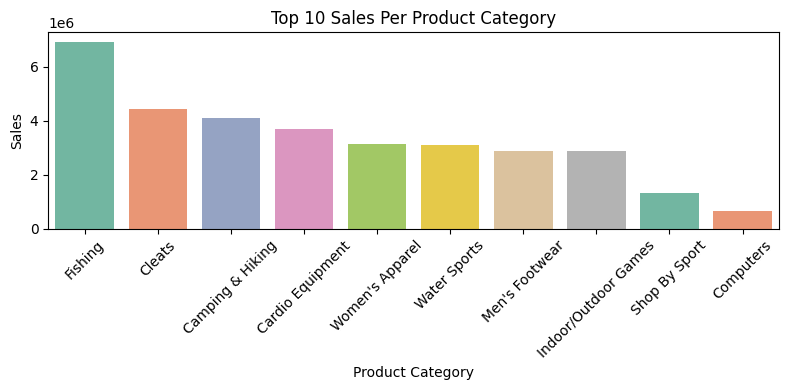

In [522]:

sales_per_category = data.groupby('Category Name')['Sales'].sum().sort_values(ascending=False)



top_10_sales_per_category = sales_per_category.head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_10_sales_per_category.index, y=top_10_sales_per_category.values, palette='Set2')
plt.title('Top 10 Sales Per Product Category')
plt.xlabel('Product Category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




This bar chart highlights the top 10 product categories in terms of sales. Fishing leads significantly with over 6 million USD in sales, followed by Cleats and Camping & Hiking, both contributing around 4 million USD. Cardio Equipment, Women's Apparel, and Water Sports show slightly lower but still substantial sales figures. Categories like Men's Footwear, Indoor/Outdoor Games, and Shop By Sport also perform well, while Computers is at the bottom of the top 10 list. 

**TOP 10 REGIONS WITH LOSS:**

In [525]:

regions_with_loss = data[data['Benefit per order'] < 0].groupby('Order Region')['Sales'].sum().sort_values(ascending=False)
regions_with_loss.head(10)


Order Region
Western Europe     1.120912e+06
Central America    1.049633e+06
South America      5.414282e+05
Northern Europe    4.023718e+05
Oceania            3.900111e+05
Southern Europe    3.764023e+05
Southeast Asia     3.519799e+05
Caribbean          3.075977e+05
South Asia         2.960052e+05
West of USA        2.951724e+05
Name: Sales, dtype: float64

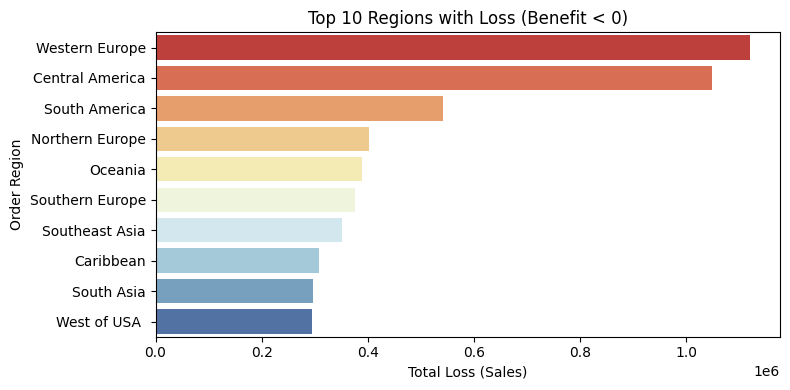

In [526]:

top_10_loss = regions_with_loss.head(10)

plt.figure(figsize=(8, 4))
sns.barplot(
    x=top_10_loss.values, 
    y=top_10_loss.index, 
    palette='RdYlBu'
)
plt.title('Top 10 Regions with Loss (Benefit < 0)')
plt.xlabel('Total Loss (Sales)')
plt.tight_layout()
plt.show()


Western Europe leads with the highest loss, followed closely by Central America and South America. Northern Europe, Oceania, and Southern Europe also show significant losses, although at a lower scale. Regions like Southeast Asia, the Caribbean, South Asia, and the West of the USA round out the list with smaller total losses. This data can guide strategic decisions to address the underlying causes of losses in these regions and explore potential areas for improvement or cost reduction.

**TOP 10 PRODUCTS WITH LOSS:**

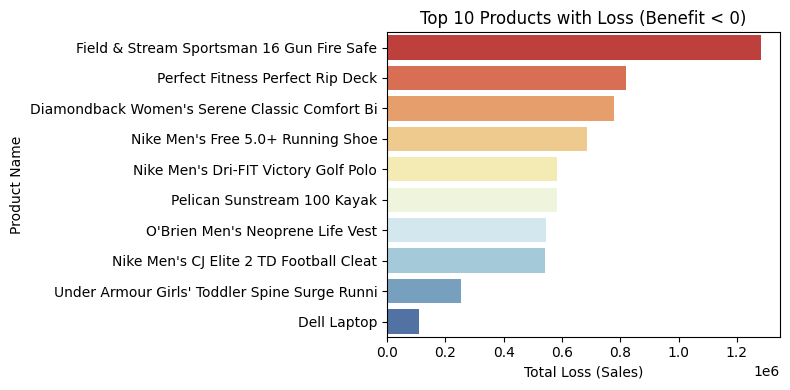

In [527]:

top_10_products_loss = data[data['Benefit per order'] < 0].groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(
    x=top_10_products_loss.values, 
    y=top_10_products_loss.index, 
    palette='RdYlBu'
)
plt.title('Top 10 Products with Loss (Benefit < 0)')
plt.xlabel('Total Loss (Sales)')
plt.tight_layout()
plt.show()

**PAYMENT TYPE VS. LATE DELIVERY RISK:**

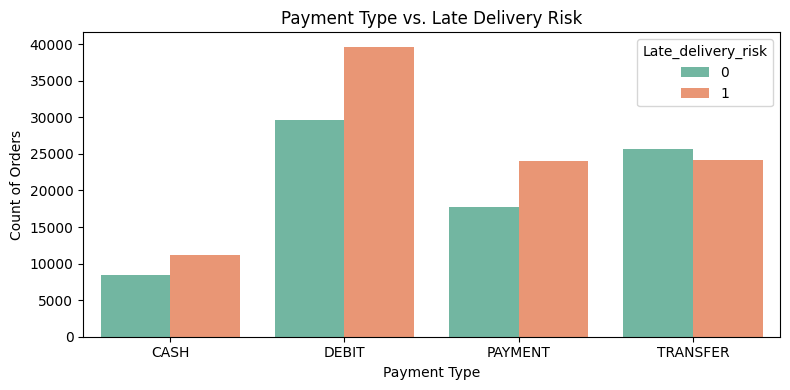

In [528]:
import matplotlib.pyplot as plt
import seaborn as sns


payment_late_risk = data.groupby(['Type', 'Late_delivery_risk']).size().reset_index(name='Count')


plt.figure(figsize=(8, 4))
sns.barplot(data=payment_late_risk, x='Type', y='Count', hue='Late_delivery_risk', palette='Set2')


plt.xlabel('Payment Type')
plt.ylabel('Count of Orders')
plt.title('Payment Type vs. Late Delivery Risk')


plt.tight_layout()
plt.show()



This bar chart illustrates the relationship between different payment types and late delivery risk. The DEBIT payment type shows the highest count of late deliveries (in orange), significantly exceeding orders delivered on time. CASH payments have the lowest number of orders overall, with fewer late deliveries than other payment types. PAYMENT and TRANSFER types have a relatively balanced split between orders delivered on time (in green) and late deliveries. The chart suggests that certain payment types, especially DEBIT, are associated with a higher late delivery risk, indicating a potential operational inefficiency or delay related to these transactions.

**NUMBER OF ORDERS FROM DIFFERENT DEPARTMENTS VS SHIPPING MODE:**

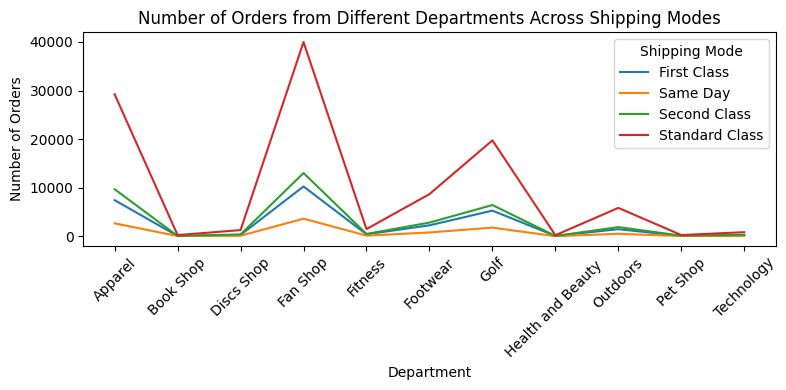

In [530]:
import matplotlib.pyplot as plt
import seaborn as sns


category_shipping = data.groupby(['Department Name', 'Shipping Mode']).size().unstack(fill_value=0)


plt.figure(figsize=(8, 4))
for mode in category_shipping.columns:
    plt.plot(category_shipping.index, category_shipping[mode], label=mode)


plt.xlabel('Department')
plt.ylabel('Number of Orders')
plt.title('Number of Orders from Different Departments Across Shipping Modes')
plt.xticks(rotation=45)


plt.legend(title='Shipping Mode')


plt.tight_layout()
plt.show()


This line chart depicts the number of orders from different departments segmented by shipping modes. Standard Class (in red) consistently dominates across most departments, with significant peaks in Fan Shop, Disc Shop, and Outdoors departments. Second Class (green) is the second most utilized shipping method but at a much lower volume compared to Standard Class. First Class (blue) and Same Day (orange) shipping methods have a relatively low number of orders across all departments, suggesting they are used less frequently. The chart highlights that customers across departments prefer Standard Class, possibly due to cost, while faster shipping modes like Same Day are much less common across all departments.

**LATE DELIVERIES VS. SHIPPING MODE VS. REGION:**

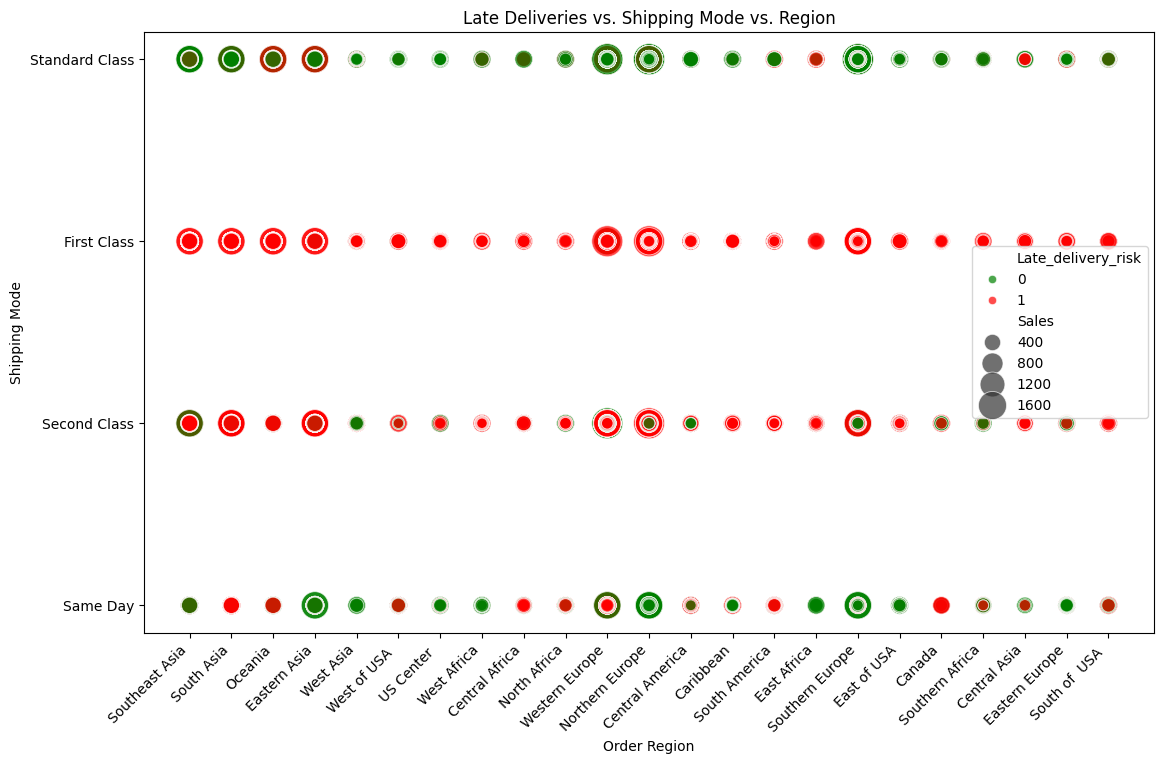

In [531]:

plt.figure(figsize=(12, 8)) 
sns.scatterplot(
    data=data, 
    x='Order Region', 
    y='Shipping Mode', 
    hue='Late_delivery_risk', 
    size='Sales', 
    sizes=(50, 500), 
    palette={0: 'green', 1: 'red'},  
    alpha=0.7
)

plt.title('Late Deliveries vs. Shipping Mode vs. Region')
plt.xticks(rotation=45, fontsize=10, ha='right')  
plt.tight_layout(pad=2)  
plt.show()



This bubble plot visualizes the relationship between shipping mode, delivery risk, and geographic region. Standard Class shows a mix of green (on-time) and red (late) deliveries across regions, with larger bubbles for regions such as Western Europe, US Center, and Northern Europe, indicating higher sales. The First Class shipping mode is predominantly associated with late deliveries (red) across most regions, especially US Center and Western Europe. Second Class displays a similar pattern with more late deliveries than on-time deliveries. Same Day service, however, shows a balanced mix of on-time and late deliveries, with larger on-time deliveries in Western Europe and US Center. The bubble sizes indicate the volume of sales, showing that Standard Class accounts for most sales but is still prone to late deliveries in specific regions. This chart suggests that shipping mode and regional factors significantly impact late delivery risks.

**DELIVERY STATUS BY SHIPPING MODE:**

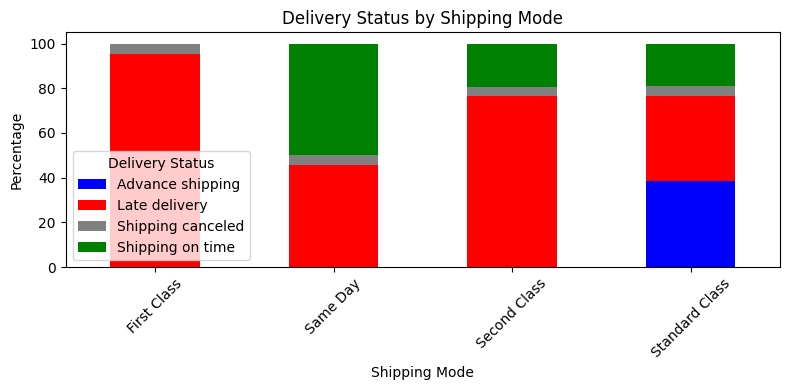

In [532]:
import matplotlib.pyplot as plt
import pandas as pd


delivery_status_percent = data.groupby(['Shipping Mode', 'Delivery Status']).size().unstack().fillna(0)


delivery_status_percent = delivery_status_percent.div(delivery_status_percent.sum(axis=1), axis=0) * 100


delivery_status_percent.plot(kind='bar', stacked=True, figsize=(8, 4), color=['blue', 'red', 'grey', 'green'])


plt.title('Delivery Status by Shipping Mode')
plt.xlabel('Shipping Mode')
plt.ylabel('Percentage')


plt.xticks(rotation=45)


plt.tight_layout()
plt.show()


First Class and Second Class modes have a high proportion of late deliveries (in red), with First Class reaching nearly 100% late deliveries. Same Day shipping has a more balanced distribution, with a significant portion of on-time deliveries (in green) and some late deliveries. Standard Class shows a mix of delivery statuses, with a notable percentage of advance shipping (in blue) and on-time deliveries. However, it also has a notable number of late deliveries. This chart emphasizes that First Class and Second Class are more prone to late deliveries, whereas Same Day and Standard Class offer a better balance of timely deliveries.

**SHIPPING DAYS VS. SHIPPING MODE**

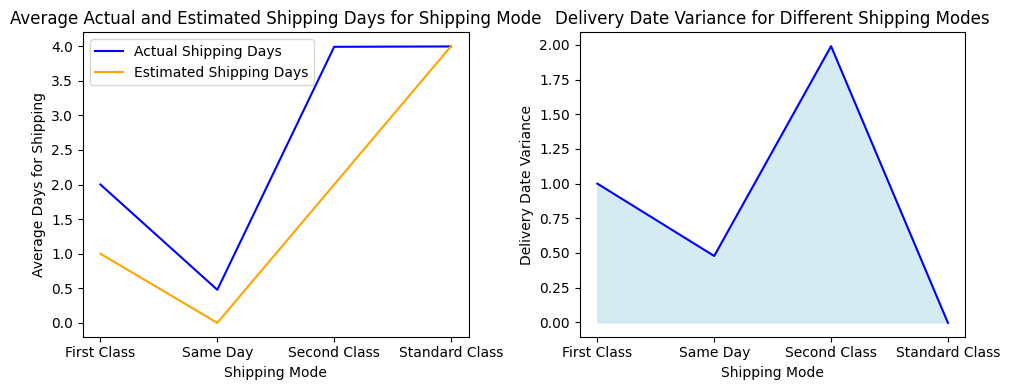

In [533]:
import matplotlib.pyplot as plt
import seaborn as sns


shipping_days = data.groupby('Shipping Mode').agg({
    'Days for shipping (real)': 'mean',
    'Days for shipment (scheduled)': 'mean'
}).reset_index()


shipping_days['Delivery Date Variance'] = shipping_days['Days for shipping (real)'] - shipping_days['Days for shipment (scheduled)']

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1: Average Actual and Estimated Shipping Days by Shipping Mode
ax[0].plot(shipping_days['Shipping Mode'], shipping_days['Days for shipping (real)'], label='Actual Shipping Days', color='blue')
ax[0].plot(shipping_days['Shipping Mode'], shipping_days['Days for shipment (scheduled)'], label='Estimated Shipping Days', color='orange')

# Adding labels and title for Subplot 1
ax[0].set_xlabel('Shipping Mode')
ax[0].set_ylabel('Average Days for Shipping')
ax[0].set_title('Average Actual and Estimated Shipping Days for Shipping Mode')
ax[0].legend()

# Subplot 2: Delivery Date Variance by Shipping Mode
ax[1].plot(shipping_days['Shipping Mode'], shipping_days['Delivery Date Variance'], label='Delivery Date Variance', color='blue')
ax[1].fill_between(shipping_days['Shipping Mode'], shipping_days['Delivery Date Variance'], color='lightblue', alpha=0.5)


ax[1].set_xlabel('Shipping Mode')
ax[1].set_ylabel('Delivery Date Variance')
ax[1].set_title('Delivery Date Variance for Different Shipping Modes')


plt.tight_layout()
plt.show()




The first chart compares the average actual and estimated shipping days across different shipping modes. For First Class and Second Class, actual shipping times (in blue) significantly exceed estimated times (in orange), indicating a clear delay. Same Day shipping is the only mode where the actual shipping days closely align with or are even slightly lower than the estimated shipping time. Standard Class shows a similar pattern to First and Second Class, with actual shipping times exceeding the estimates, though not as drastically.

The second chart illustrates the delivery date variance across shipping modes, showing how much the actual delivery times fluctuate. Second Class shows the highest variance, indicating more inconsistency in delivery times, while Standard Class has the lowest variance, suggesting more predictable shipping times. First Class and Same Day show moderate variance, with Same Day having slightly lower fluctuation compared to First Class. This reinforces the idea that Second Class shipping is more prone to delays and inconsistencies, while Same Day provides the most reliable performance.

### 2.1 CORRELATION ANALYSIS

In [534]:
numerical_data = data.select_dtypes(include = ['number']).copy()
numerical_data.head(2)

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
0,3,4,91.250000,314.640015,0,73,20755,725.0,2,18.251453,...,1,327.75,314.640015,91.250000,NaN,1360,73,NaN,327.75,0
1,5,4,-249.089996,311.359985,1,73,19492,725.0,2,18.279451,...,1,327.75,311.359985,-249.089996,NaN,1360,73,NaN,327.75,0


In [535]:
corr_pearson = numerical_data.corr(method = 'pearson')
corr_pearson

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
Days for shipping (real),1.000000,0.515880,-0.005101,0.001757,0.401415,-0.000348,0.003432,0.000112,-0.001631,-0.004073,...,-0.000811,0.001962,0.001757,-0.005101,-0.000811,-0.000859,-0.000348,NaN,0.002185,NaN
Days for shipment (scheduled),0.515880,1.000000,-0.000185,0.006445,-0.369352,-0.000367,0.000899,-0.003019,-0.000262,-0.005300,...,-0.002925,0.006327,0.006445,-0.000185,0.005249,-0.000431,-0.000367,NaN,0.006912,NaN
Benefit per order,-0.005101,-0.000185,1.000000,0.133484,-0.003727,0.031889,0.009354,0.002235,0.031442,0.000338,...,0.015696,0.131816,0.133484,1.000000,-0.004978,0.033161,0.031889,NaN,0.103459,NaN
Sales per customer,0.001757,0.006445,0.133484,1.000000,-0.003791,0.225201,0.060181,-0.001304,0.232367,-0.000223,...,0.105413,0.989744,1.000000,0.133484,-0.000138,0.236367,0.225201,NaN,0.781781,NaN
Late_delivery_risk,0.401415,-0.369352,-0.003727,-0.003791,1.000000,0.001752,0.001484,0.003148,0.001077,0.000679,...,-0.000139,-0.003564,-0.003791,-0.003727,-0.014131,0.001490,0.001752,NaN,-0.002175,NaN
Category Id,-0.000348,-0.000367,0.031889,0.225201,0.001752,1.000000,0.274633,0.002898,0.888835,0.002195,...,-0.302408,0.227483,0.225201,0.031889,-0.005943,0.991092,1.000000,NaN,0.461059,NaN
Customer Id,0.003432,0.000899,0.009354,0.060181,0.001484,0.274633,1.000000,0.002022,0.136897,0.002335,...,-0.091328,0.060961,0.060181,0.009354,-0.005659,0.228039,0.274633,NaN,0.111118,NaN
Customer Zipcode,0.000112,-0.003019,0.002235,-0.001304,0.003148,0.002898,0.002022,1.000000,0.002878,0.584553,...,-0.006174,-0.001490,-0.001304,0.002235,0.011843,0.003173,0.002898,NaN,0.002191,NaN
Department Id,-0.001631,-0.000262,0.031442,0.232367,0.001077,0.888835,0.136897,0.002878,1.000000,0.002460,...,-0.265437,0.234718,0.232367,0.031442,-0.005982,0.906117,0.888835,NaN,0.446743,NaN
Latitude,-0.004073,-0.005300,0.000338,-0.000223,0.000679,0.002195,0.002335,0.584553,0.002460,1.000000,...,-0.001853,-0.000696,-0.000223,0.000338,-0.002921,0.002031,0.002195,NaN,0.000471,NaN


In [536]:
corr_pearson["Late_delivery_risk"].sort_values(ascending = False)

Late_delivery_risk               1.000000
Days for shipping (real)         0.401415
Customer Zipcode                 0.003148
Product Category Id              0.001752
Category Id                      0.001752
Product Card Id                  0.001490
Order Item Cardprod Id           0.001490
Customer Id                      0.001484
Order Customer Id                0.001484
Department Id                    0.001077
Latitude                         0.000679
Order Item Discount Rate         0.000404
Order Item Quantity             -0.000139
Order Item Discount             -0.000750
Order Id                        -0.001293
Order Item Id                   -0.001376
Longitude                       -0.001915
Order Item Product Price        -0.002175
Product Price                   -0.002175
Order Item Profit Ratio         -0.002316
Sales                           -0.003564
Benefit per order               -0.003727
Order Profit Per Order          -0.003727
Order Item Total                -0

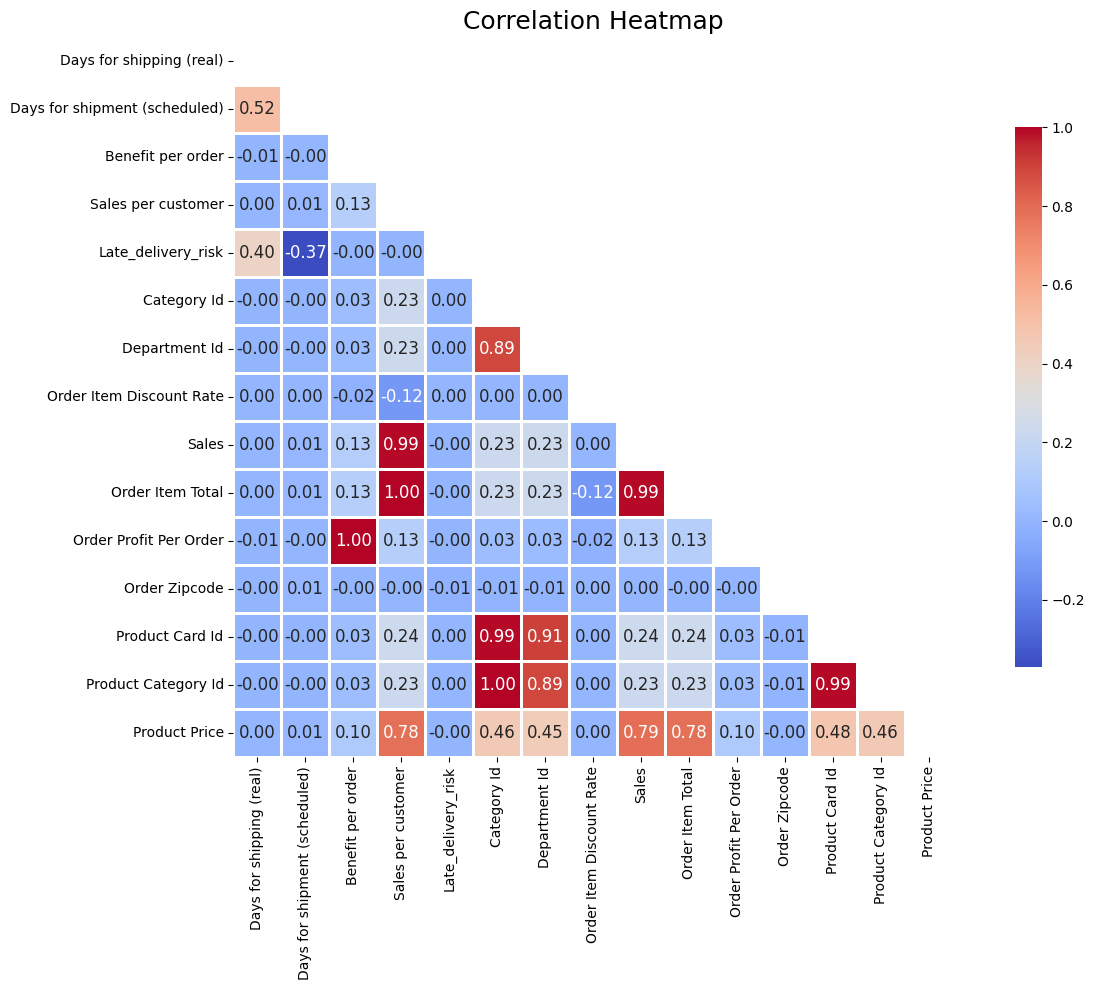

In [537]:
# Useless columns to drop
columns_to_drop = [
    'Customer Id', 'Customer Zipcode', 'Latitude', 'Longitude', 'Order Customer Id', 
    'Order Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Id',
    'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity',
    'Product Description', 'Product Status'
]


numerical_df_cleaned = numerical_data.drop(columns=columns_to_drop)


corr_pearson = numerical_df_cleaned.corr()


plt.figure(figsize=(14, 10))  


mask = np.triu(np.ones_like(corr_pearson, dtype=bool))


sns.heatmap(
    corr_pearson,
    annot=True,  
    fmt=".2f",   
    cmap='coolwarm',  
    mask=mask,  
    square=True,  
    annot_kws={"size": 12},  
    cbar_kws={"shrink": 0.75},  
    linewidths=1,  # Increase line width for better square separation
)


plt.title('Correlation Heatmap', fontsize=18)


plt.tight_layout()
plt.show()



Days for shipping (real) and Late delivery risk show a moderate positive correlation of 0.40, indicating that as actual shipping days increase, the likelihood of late delivery also increases. Conversely, Days for shipment (scheduled) shows a negative correlation of -0.37 with late delivery risk, meaning that when shipments are planned for longer durations, they are less likely to be late, possibly because expectations for longer delivery times are set upfront.

There is a strong positive correlation between Sales, Order Item Total, and Order Profit Per Order, which is expected since these metrics are interrelated (sales and order totals drive profit). Product Card ID and Product Category ID also show strong correlations, indicating a connection between product categories and specific product types. Additionally, Department ID shows a high correlation with Category ID (0.89), reinforcing the fact that certain departments are tied to specific product categories. Overall, the heatmap highlights significant relationships that can be leveraged for further predictive insights.

### 2. DATA CLEANING

**2.1 MISSING VALUES**

In [538]:
data.isnull().sum()

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [539]:
data.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,...,180519.000000,180519.000000,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,...,2.127638,203.772096,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,...,1.453451,132.273077,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,...,1.000000,119.980003,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,...,1.000000,199.919998,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,...,3.000000,299.950012,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,...,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


In [540]:
# More useless columns to drop

columns_to_drop = ['Order Zipcode', 'Product Description', 'Customer Id', 'Order Id', 'Product Card Id', 
                   'Latitude', 'Longitude', 'Customer Email', 'Customer Fname', 
                   'Customer Lname', 'Customer Password', 'Customer Street', 
                   'Order Item Cardprod Id', 'Order Customer Id', 
                   'Product Image', 'Product Name', 'Category Name', 'Customer State', 
                   'Customer Zipcode', 'Department Name']


data_cleaned = data.drop(columns=columns_to_drop)



**2.2 OUTLIERS**

In [541]:
numerical_data = data_cleaned.select_dtypes(include = ['number']).copy()
numerical_data.head(2)

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Department Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Product Category Id,Product Price,Product Status
0,3,4,91.250000,314.640015,0,73,2,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,73,327.75,0
1,5,4,-249.089996,311.359985,1,73,2,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,73,327.75,0


In [542]:
numerical_data.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Department Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Product Category Id,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,5.443460,20.664741,0.101668,90260.000000,141.232550,0.120647,2.127638,203.772096,183.107609,21.974989,31.851451,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,1.629246,21.800901,0.070415,52111.490959,139.732492,0.466796,1.453451,132.273077,120.043670,104.433526,15.640064,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,2.000000,0.000000,0.000000,1.000000,9.990000,-2.750000,1.000000,9.990000,7.490000,-4274.979980,2.000000,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,4.000000,5.400000,0.040000,45130.500000,50.000000,0.080000,1.000000,119.980003,104.379997,7.000000,18.000000,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,5.000000,14.000000,0.100000,90260.000000,59.990002,0.270000,1.000000,199.919998,163.990005,31.520000,29.000000,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,7.000000,29.990000,0.160000,135389.500000,199.990005,0.360000,3.000000,299.950012,247.399994,64.800003,45.000000,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,12.000000,500.000000,0.250000,180519.000000,1999.989990,0.500000,5.000000,1999.989990,1939.989990,911.799988,76.000000,1999.989990,0.0


**Features to be used for Outliers Analysis:**

- *Benefit per Order*: High or low benefit per order could indicate discrepancies in the shipping or handling costs, which might lead to a delay. For example, a low benefit might mean excessive costs on logistics, causing delays due to financial inefficiency.

- *Order Item Discount Rate*: High discounts might attract more sales volume, which could put pressure on fulfillment systems, leading to delays. If the discount rates are too high, it may indicate special promotions that led to increased demand, potentially overwhelming supply chains and causing delays.

- *Order Profit Per Order*: Similar to benefit per order, orders with low or negative profit might be handled with less priority, causing delays. Conversely, highly profitable orders might be given higher priority, reducing the risk of delay.

- *Product Price* High-priced items might require special handling or transportation, increasing the complexity of delivery and raising the risk of delays.

- *Sales per Customer*: Outliers in sales per customer could indicate high-volume or bulk buyers, where fulfilling large orders could take longer, increasing delivery risk.

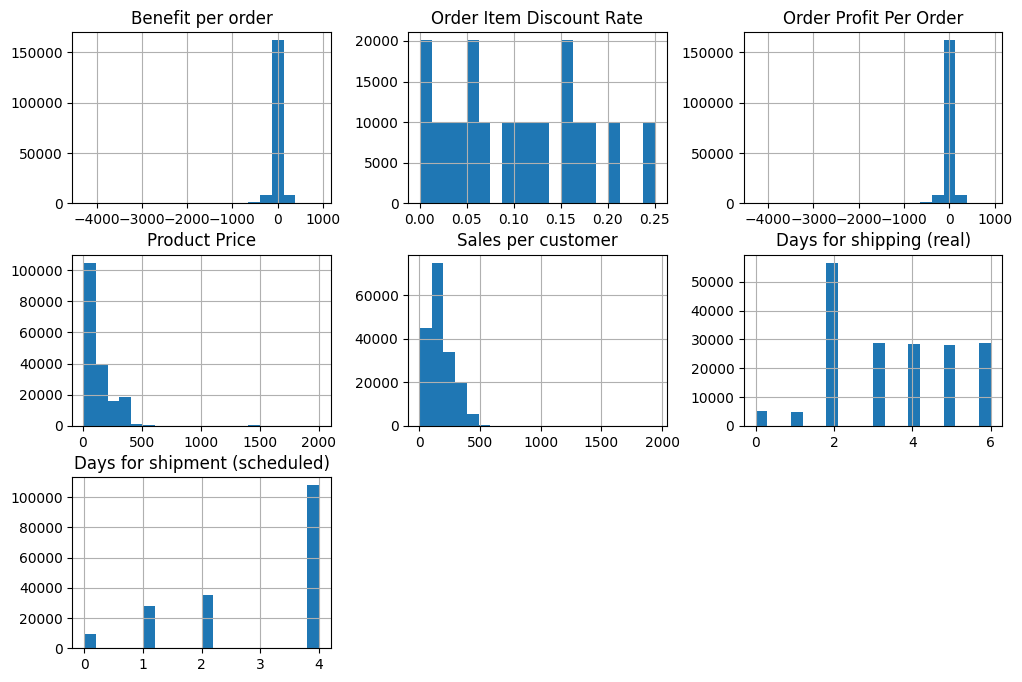

In [543]:
data_cleaned[["Benefit per order", "Order Item Discount Rate", "Order Profit Per Order", "Product Price", "Sales per customer", "Days for shipping (real)", "Days for shipment (scheduled)"]].hist(bins=20, layout=(3, 3), figsize=(12, 8))

plt.xticks(fontsize=3)
plt.yticks(fontsize=3)

plt.show()

Since "Days for shipping (real)" and "Days for shipment (scheduled)" have a fairly normal distribution and are highly correlated with the target variable "Late delivery risk," keeping the outliers in these feature can preserve its predictive power. The outliers in features that show a strong correlation with the target might represent key variations that contribute to the risk of late delivery, especially when considering delivery time. 

Based on the histogram above, the Order Item Discount Rate does look relatively normal, with distinct, spaced-out bars that likely reflect fixed discount tiers (e.g., 5%, 10%, etc.). The values appear to be well-distributed across the expected range, and there don't seem to be any extreme outliers that would raise concern.

On the other hand, for features with very low correlation with the target (like customer information), the outliers might not play an important role, and cleaning them up (removing or replacing them) wouldn't significantly affect the model's predictive accuracy:

- Z-score for "Benefit per Order" and "Order Profit per Order": Both of these are more likely to have normally distributed data (or close to it). Z-score works well for identifying outliers in normal distributions, as it measures how far a data point is from the mean in terms of standard deviations.

- IQR for "Product Price" and "Sales per Customer": These are  right-skewed distributions. IQR is better at handling skewed distributions because it looks at the spread of the middle 50% of data and flags anything significantly outside that range as an outlier.


In [544]:

from scipy import stats

# Z-Score Method for Benefit per Order and Order Profit per Order
def z_score_outliers(data):
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std
    return np.abs(z_scores) > threshold

def iqr_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

z_score_outliers_benefit = z_score_outliers(data_cleaned["Benefit per order"])
z_score_outliers_profit = z_score_outliers(data_cleaned["Order Profit Per Order"])

                                
iqr_outliers_product_price = iqr_outliers(data_cleaned["Product Price"])
iqr_outliers_sales_customer = iqr_outliers(data_cleaned["Sales per customer"])
                                           


print(f"Number of outliers in Benefit per Order (Z-score): {z_score_outliers_benefit.sum()}")
print(f"Number of outliers in Order Profit Per Order (Z-score): {z_score_outliers_profit.sum()}")
print(f"Number of outliers in Product Price (IQR): {iqr_outliers_product_price.sum()}")
print(f"Number of outliers in Sales per Customer (IQR): {iqr_outliers_sales_customer.sum()}")


Number of outliers in Benefit per Order (Z-score): 3608
Number of outliers in Order Profit Per Order (Z-score): 3608
Number of outliers in Product Price (IQR): 2048
Number of outliers in Sales per Customer (IQR): 1943


When dealing with outliers, replacing them with the median is often the best choice, especially when the data is skewed. The median is a robust measure of central tendency that isn’t affected by extreme values as much as the mean.

**Skewness and Impact on Outliers:**

Right-skewed data (e.g., Product Price, Sales per Customer) has a longer tail on the right, meaning there are a few very high values pulling the mean up. In this case, replacing outliers with the median makes sense, as it better reflects the typical values without being distorted by those extreme high points.

Left-skewed data (e.g., Benefit per Order, Order Profit Per Order) has a longer tail on the left (negative values). Replacing outliers with the median here ensures that the extreme negative values don’t overly influence the analysis, providing a more balanced representation of your data.

In [545]:
median_benefit = data_cleaned["Benefit per order"].median()
data_cleaned.loc[z_score_outliers_benefit, "Benefit per order"] = median_benefit

median_profit = data_cleaned["Order Profit Per Order"].median()
data_cleaned.loc[z_score_outliers_profit, "Order Profit Per Order"] = median_profit

median_product_price = data_cleaned["Product Price"].median()
data_cleaned.loc[iqr_outliers_product_price, "Product Price"] = median_product_price

median_sales_customer = data_cleaned["Sales per customer"].median()
data_cleaned.loc[iqr_outliers_sales_customer, "Sales per customer"] = median_sales_customer

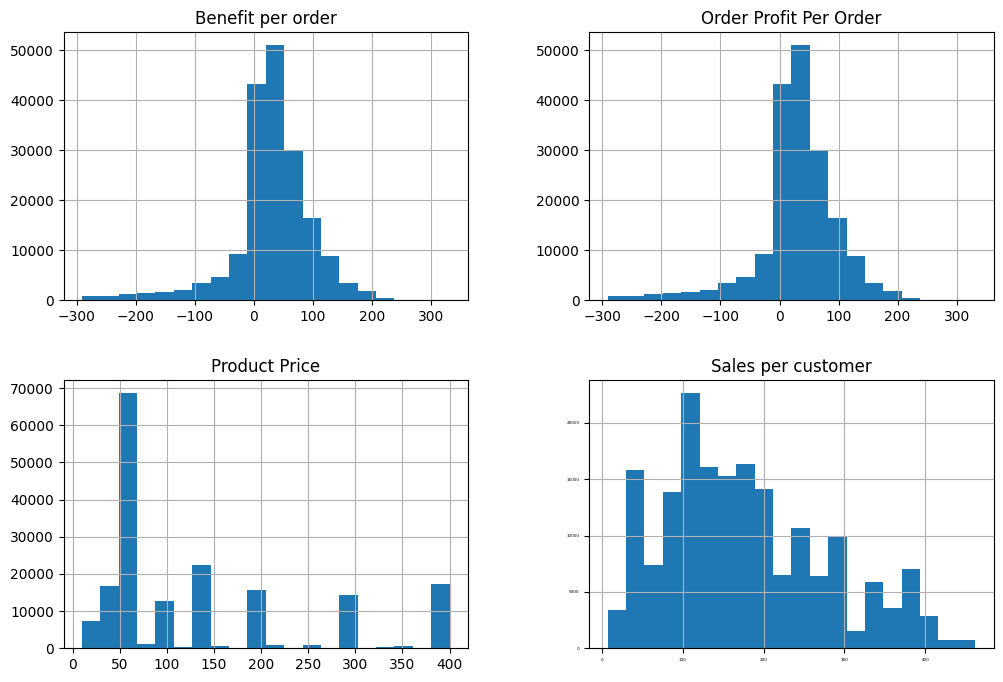

In [546]:
data_cleaned[["Benefit per order", "Order Profit Per Order", "Product Price", "Sales per customer"]].hist(bins=20, layout=(2, 2), figsize=(12, 8))

plt.xticks(fontsize=3)
plt.yticks(fontsize=3)

plt.show()

In [547]:
data_cleaned.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Delivery Status                   object
Late_delivery_risk                 int64
Category Id                        int64
Customer City                     object
Customer Country                  object
Customer Segment                  object
Department Id                      int64
Market                            object
Order City                        object
Order Country                     object
order date (DateOrders)           object
Order Item Discount              float64
Order Item Discount Rate         float64
Order Item Id                      int64
Order Item Product Price         float64
Order Item Profit Ratio          float64
Order Item Quantity                int64
Sales                            float64
Order Item Total                 float64
Order Profit Per

### 3. FEATURE SELECTION

**3.1 CATEGORICAL FEATURES SELECTION**

In [548]:
categorical_data = data_cleaned.select_dtypes(include = ['object']).copy()
categorical_data["y"] = data_cleaned["Late_delivery_risk"]
categorical_data.head(5)

,Type,Delivery Status,Customer City,Customer Country,Customer Segment,Market,Order City,Order Country,order date (DateOrders),Order Region,Order State,Order Status,shipping date (DateOrders),Shipping Mode,y
0,DEBIT,Advance shipping,Caguas,Puerto Rico,Consumer,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,Southeast Asia,Java Occidental,COMPLETE,2/3/2018 22:56,Standard Class,0
1,TRANSFER,Late delivery,Caguas,Puerto Rico,Consumer,Pacific Asia,Bikaner,India,1/13/2018 12:27,South Asia,Rajastán,PENDING,1/18/2018 12:27,Standard Class,1
2,CASH,Shipping on time,San Jose,EE. UU.,Consumer,Pacific Asia,Bikaner,India,1/13/2018 12:06,South Asia,Rajastán,CLOSED,1/17/2018 12:06,Standard Class,0
3,DEBIT,Advance shipping,Los Angeles,EE. UU.,Home Office,Pacific Asia,Townsville,Australia,1/13/2018 11:45,Oceania,Queensland,COMPLETE,1/16/2018 11:45,Standard Class,0
4,PAYMENT,Advance shipping,Caguas,Puerto Rico,Corporate,Pacific Asia,Townsville,Australia,1/13/2018 11:24,Oceania,Queensland,PENDING_PAYMENT,1/15/2018 11:24,Standard Class,0


In [549]:
X_cat = categorical_data.drop(columns = ["y"])
y_cat = categorical_data["y"]

In [550]:
import pandas as pd
from scipy.stats import chi2_contingency

for col in X_cat.columns:
    table = pd.crosstab(X_cat[col], y_cat)
    print ('\n', table)
    _, pval, _, expected_table = chi2_contingency(table)
    print('Feature:', col, '| p-value:', pval)


 y             0      1
Type                  
CASH       8507  11109
DEBIT     29646  39649
PAYMENT   17721  24004
TRANSFER  25668  24215
Feature: Type | p-value: 5.128672571053333e-239

 y                      0      1
Delivery Status                
Advance shipping   41592      0
Late delivery          0  98977
Shipping canceled   7754      0
Shipping on time   32196      0
Feature: Delivery Status | p-value: 0.0

 y                0    1
Customer City          
Aguadilla       30   20
Alameda         71   47
Albany          40   31
Albuquerque    214  338
Algonquin       47   81
...            ...  ...
Yonkers         56   82
York            99  142
Ypsilanti       69   75
Yuma            29   63
Zanesville      47   68

[563 rows x 2 columns]
Feature: Customer City | p-value: 1.727279395129362e-141

 y                     0      1
Customer Country              
EE. UU.           50160  60986
Puerto Rico       31382  37991
Feature: Customer Country | p-value: 0.660935525163501

 

In [551]:
data_cleaned["Order City"].nunique()

3597

We are removing Customer Country, Customer Segment, and Market because they have the highest p-values, indicating that they are not statistically significant in predicting late delivery risk. Features with high p-values are less likely to contribute meaningful insights to the model, as they do not show a strong association with the target variable.

We are also removing Delivery Status because it directly correlates with the target (Late Delivery - Late Delivery Risk), making it redundant. Customer City and Order City are being dropped due to their high cardinality (3000+ unique values), which adds complexity without offering much predictive value. Similarly, Order Region is redundant similar as Customer Country has shown low p-value with weak association with the target variable. Order State is also being removed for the same reason as Order City—too many unique values. Finally, Order Status is unnecessary because we are only interested in predicting late deliveries for completed, paid orders, not those still in processing or canceled. This streamlines the dataset and focuses on relevant, predictive features.

In [552]:
columns_to_remove = ['Customer Country', 'Customer Segment', 'Market', 'Delivery Status', 
                     'Customer City', 'Order City', 'Order Region', 'Order State', 'Order Status']


data_cleaned = data_cleaned.drop(columns=columns_to_remove)


**NUMERICAL FEATURES SELECTION**

In [553]:
numeric_mask1 = data_cleaned.select_dtypes(include='number').columns
numeric_features1 = data_cleaned[numeric_mask1]

In [554]:
from sklearn.feature_selection import VarianceThreshold

var_th = VarianceThreshold(threshold=0.05)
var_th.fit_transform(numeric_features1)

array([[   3.       ,    4.       ,   91.25     , ...,   91.25     ,
          73.       ,  327.75     ],
       [   5.       ,    4.       , -249.0899963, ..., -249.0899963,
          73.       ,  327.75     ],
       [   4.       ,    4.       , -247.7799988, ..., -247.7799988,
          73.       ,  327.75     ],
       ...,
       [   5.       ,    4.       ,  141.1100006, ...,  141.1100006,
          45.       ,  399.980011 ],
       [   3.       ,    4.       ,  186.2299957, ...,  186.2299957,
          45.       ,  399.980011 ],
       [   4.       ,    4.       ,  168.9499969, ...,  168.9499969,
          45.       ,  399.980011 ]])

In [555]:

numeric_features1.head()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Department Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Product Category Id,Product Price,Product Status
0,3,4,91.250000,314.640015,0,73,2,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,73,327.75,0
1,5,4,-249.089996,311.359985,1,73,2,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,73,327.75,0
2,4,4,-247.779999,309.720001,0,73,2,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,73,327.75,0
3,3,4,22.860001,304.809998,0,73,2,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,73,327.75,0
4,2,4,134.210007,298.250000,0,73,2,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,73,327.75,0


In [556]:
var_th.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False])

In [557]:
X_num = numeric_features1.drop(columns = ["Late_delivery_risk"]) 
y_num = numeric_features1["Late_delivery_risk"]  

In [558]:
import scipy
import numpy as np

print(f"{'col':<30} {'corr':<10} {'pval':<10}")
for col in X_num.columns:
    corr = np.nan
    pval = np.nan
    if X_num[col].nunique() > 1:  # Check if column has more than one unique value
        corr, pval = scipy.stats.pearsonr(X_num[col], y_num)
    
    print(f"{col:<30} {corr:>10.2f} {pval:>10.4f}")


col                            corr       pval      
Days for shipping (real)             0.40     0.0000
Days for shipment (scheduled)       -0.37     0.0000
Benefit per order                   -0.00     0.6436
Sales per customer                  -0.00     0.5831
Category Id                          0.00     0.4568
Department Id                        0.00     0.6473
Order Item Discount                 -0.00     0.7500
Order Item Discount Rate             0.00     0.8636
Order Item Id                       -0.00     0.5589
Order Item Product Price            -0.00     0.3554
Order Item Profit Ratio             -0.00     0.3252
Order Item Quantity                 -0.00     0.9528
Sales                               -0.00     0.1299
Order Item Total                    -0.00     0.1072
Order Profit Per Order              -0.00     0.6436
Product Category Id                  0.00     0.4568
Product Price                       -0.00     0.6764
Product Status                        nan     

In [559]:
from sklearn.feature_selection import mutual_info_regression
list(zip(X_num.columns, mutual_info_regression(X_num, y_num, random_state=123, n_neighbors=3)))

[('Days for shipping (real)', 0.23589606645570171),
 ('Days for shipment (scheduled)', 0.11785383423000795),
 ('Benefit per order', 0.0),
 ('Sales per customer', 0.0),
 ('Category Id', 0.0),
 ('Department Id', 0.001732394746310817),
 ('Order Item Discount', 0.0),
 ('Order Item Discount Rate', 0.002555342281704398),
 ('Order Item Id', 0.3789144206694264),
 ('Order Item Product Price', 0.0),
 ('Order Item Profit Ratio', 0.00018182956002732453),
 ('Order Item Quantity', 0.0),
 ('Sales', 0.0),
 ('Order Item Total', 0.0),
 ('Order Profit Per Order', 0.0),
 ('Product Category Id', 0.0),
 ('Product Price', 0.001050569128880241),
 ('Product Status', 0.0)]

Based on the analysis, we decided to remove the feature Order Item Discount Rate because it was identified by the variance threshold method as having a variance lower than the set threshold, meaning it provides little to no information for distinguishing between records. 

Additionally, the feature Product Status showed a correlation of NaN with the target, and it was deemed irrelevant according to the mutual information analysis, where it scored 0. These features, therefore, do not provide significant or meaningful contributions to predicting the risk of late delivery and can be safely excluded from the model to avoid adding noise or unnecessary complexity.

In [560]:

features_to_remove = ['Order Item Discount Rate', 'Product Status']

data_cleaned = data_cleaned.drop(columns=features_to_remove)


In [561]:
data_cleaned.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Late_delivery_risk                 int64
Category Id                        int64
Department Id                      int64
Order Country                     object
order date (DateOrders)           object
Order Item Discount              float64
Order Item Id                      int64
Order Item Product Price         float64
Order Item Profit Ratio          float64
Order Item Quantity                int64
Sales                            float64
Order Item Total                 float64
Order Profit Per Order           float64
Product Category Id                int64
Product Price                    float64
shipping date (DateOrders)        object
Shipping Mode                     object
dtype: object

In [562]:
data_cleaned["Order Item Profit Ratio"].nunique()

162

In [563]:
data_cleaned["Order Item Id"].unique()

array([180517, 179254, 179253, ...,  65129,  65126,  65113], dtype=int64)

In [564]:
data_cleaned = data_cleaned.drop(columns = "Order Item Id")

In [565]:
data_cleaned.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Late_delivery_risk                 int64
Category Id                        int64
Department Id                      int64
Order Country                     object
order date (DateOrders)           object
Order Item Discount              float64
Order Item Product Price         float64
Order Item Profit Ratio          float64
Order Item Quantity                int64
Sales                            float64
Order Item Total                 float64
Order Profit Per Order           float64
Product Category Id                int64
Product Price                    float64
shipping date (DateOrders)        object
Shipping Mode                     object
dtype: object

### 4. NEW FEATURES CREATION

Creating new features based on time format features such as "shipping date(DateOrders)".

In [566]:
# Convert the columns to datetime format
data_cleaned['shipping date (DateOrders)'] = pd.to_datetime(data_cleaned['shipping date (DateOrders)'])
data_cleaned['order date (DateOrders)'] = pd.to_datetime(data_cleaned['order date (DateOrders)'])

data_cleaned['diff(hours)'] = ((data_cleaned['shipping date (DateOrders)'] - data_cleaned['order date (DateOrders)']).astype('timedelta64[s]') / pd.Timedelta(hours=1)).astype(int)
data_cleaned['diff(hours)'].values

array([ 72, 120,  96, ..., 120,  72,  96])

In [567]:
data_cleaned['ship_day_of_week'] = data_cleaned['shipping date (DateOrders)'].dt.dayofweek
data_cleaned.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Department Id,Order Country,order date (DateOrders),...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Product Category Id,Product Price,shipping date (DateOrders),Shipping Mode,diff(hours),ship_day_of_week
0,DEBIT,3,4,91.250000,314.640015,0,73,2,Indonesia,2018-01-31 22:56:00,...,1,327.75,314.640015,91.250000,73,327.75,2018-02-03 22:56:00,Standard Class,72,5
1,TRANSFER,5,4,-249.089996,311.359985,1,73,2,India,2018-01-13 12:27:00,...,1,327.75,311.359985,-249.089996,73,327.75,2018-01-18 12:27:00,Standard Class,120,3
2,CASH,4,4,-247.779999,309.720001,0,73,2,India,2018-01-13 12:06:00,...,1,327.75,309.720001,-247.779999,73,327.75,2018-01-17 12:06:00,Standard Class,96,2
3,DEBIT,3,4,22.860001,304.809998,0,73,2,Australia,2018-01-13 11:45:00,...,1,327.75,304.809998,22.860001,73,327.75,2018-01-16 11:45:00,Standard Class,72,1
4,PAYMENT,2,4,134.210007,298.250000,0,73,2,Australia,2018-01-13 11:24:00,...,1,327.75,298.250000,134.210007,73,327.75,2018-01-15 11:24:00,Standard Class,48,0


In [568]:
data_cleaned['order_day_of_week'] = data_cleaned['order date (DateOrders)'].dt.dayofweek
data_cleaned.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Department Id,Order Country,order date (DateOrders),...,Sales,Order Item Total,Order Profit Per Order,Product Category Id,Product Price,shipping date (DateOrders),Shipping Mode,diff(hours),ship_day_of_week,order_day_of_week
0,DEBIT,3,4,91.250000,314.640015,0,73,2,Indonesia,2018-01-31 22:56:00,...,327.75,314.640015,91.250000,73,327.75,2018-02-03 22:56:00,Standard Class,72,5,2
1,TRANSFER,5,4,-249.089996,311.359985,1,73,2,India,2018-01-13 12:27:00,...,327.75,311.359985,-249.089996,73,327.75,2018-01-18 12:27:00,Standard Class,120,3,5
2,CASH,4,4,-247.779999,309.720001,0,73,2,India,2018-01-13 12:06:00,...,327.75,309.720001,-247.779999,73,327.75,2018-01-17 12:06:00,Standard Class,96,2,5
3,DEBIT,3,4,22.860001,304.809998,0,73,2,Australia,2018-01-13 11:45:00,...,327.75,304.809998,22.860001,73,327.75,2018-01-16 11:45:00,Standard Class,72,1,5
4,PAYMENT,2,4,134.210007,298.250000,0,73,2,Australia,2018-01-13 11:24:00,...,327.75,298.250000,134.210007,73,327.75,2018-01-15 11:24:00,Standard Class,48,0,5


In [569]:
data_cleaned['ship_day_of_week_name'] = data_cleaned['ship_day_of_week'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})
data_cleaned['order_day_of_week_name'] = data_cleaned['order_day_of_week'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

<Axes: xlabel='count', ylabel='order_day_of_week_name'>

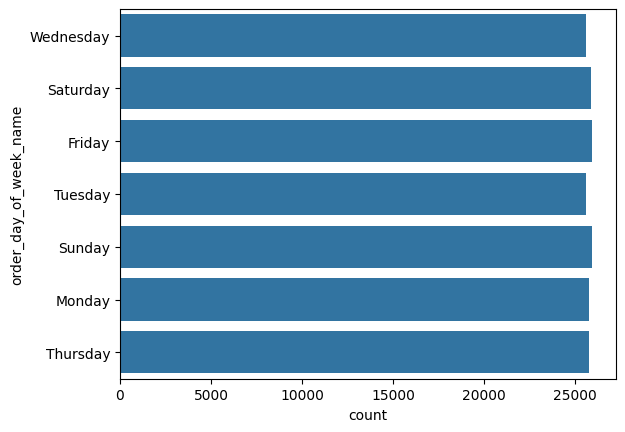

In [570]:
sns.countplot(y='order_day_of_week_name', data=data_cleaned)

In [571]:
data_cleaned['ship_hour'] = data_cleaned['shipping date (DateOrders)'].dt.hour
data_cleaned.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Department Id,Order Country,order date (DateOrders),...,Product Category Id,Product Price,shipping date (DateOrders),Shipping Mode,diff(hours),ship_day_of_week,order_day_of_week,ship_day_of_week_name,order_day_of_week_name,ship_hour
0,DEBIT,3,4,91.250000,314.640015,0,73,2,Indonesia,2018-01-31 22:56:00,...,73,327.75,2018-02-03 22:56:00,Standard Class,72,5,2,Saturday,Wednesday,22
1,TRANSFER,5,4,-249.089996,311.359985,1,73,2,India,2018-01-13 12:27:00,...,73,327.75,2018-01-18 12:27:00,Standard Class,120,3,5,Thursday,Saturday,12
2,CASH,4,4,-247.779999,309.720001,0,73,2,India,2018-01-13 12:06:00,...,73,327.75,2018-01-17 12:06:00,Standard Class,96,2,5,Wednesday,Saturday,12
3,DEBIT,3,4,22.860001,304.809998,0,73,2,Australia,2018-01-13 11:45:00,...,73,327.75,2018-01-16 11:45:00,Standard Class,72,1,5,Tuesday,Saturday,11
4,PAYMENT,2,4,134.210007,298.250000,0,73,2,Australia,2018-01-13 11:24:00,...,73,327.75,2018-01-15 11:24:00,Standard Class,48,0,5,Monday,Saturday,11


In [572]:
data_cleaned['order_hour'] = data_cleaned['order date (DateOrders)'].dt.hour
data_cleaned.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Department Id,Order Country,order date (DateOrders),...,Product Price,shipping date (DateOrders),Shipping Mode,diff(hours),ship_day_of_week,order_day_of_week,ship_day_of_week_name,order_day_of_week_name,ship_hour,order_hour
0,DEBIT,3,4,91.250000,314.640015,0,73,2,Indonesia,2018-01-31 22:56:00,...,327.75,2018-02-03 22:56:00,Standard Class,72,5,2,Saturday,Wednesday,22,22
1,TRANSFER,5,4,-249.089996,311.359985,1,73,2,India,2018-01-13 12:27:00,...,327.75,2018-01-18 12:27:00,Standard Class,120,3,5,Thursday,Saturday,12,12
2,CASH,4,4,-247.779999,309.720001,0,73,2,India,2018-01-13 12:06:00,...,327.75,2018-01-17 12:06:00,Standard Class,96,2,5,Wednesday,Saturday,12,12
3,DEBIT,3,4,22.860001,304.809998,0,73,2,Australia,2018-01-13 11:45:00,...,327.75,2018-01-16 11:45:00,Standard Class,72,1,5,Tuesday,Saturday,11,11
4,PAYMENT,2,4,134.210007,298.250000,0,73,2,Australia,2018-01-13 11:24:00,...,327.75,2018-01-15 11:24:00,Standard Class,48,0,5,Monday,Saturday,11,11


In [573]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [574]:
# ship daypart
data_cleaned['ship_daypart'] = data_cleaned['ship_hour'].apply(f)
# order daypart
data_cleaned['order_daypart'] = data_cleaned['order_hour'].apply(f)
data_cleaned.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Department Id,Order Country,order date (DateOrders),...,Shipping Mode,diff(hours),ship_day_of_week,order_day_of_week,ship_day_of_week_name,order_day_of_week_name,ship_hour,order_hour,ship_daypart,order_daypart
0,DEBIT,3,4,91.250000,314.640015,0,73,2,Indonesia,2018-01-31 22:56:00,...,Standard Class,72,5,2,Saturday,Wednesday,22,22,Night,Night
1,TRANSFER,5,4,-249.089996,311.359985,1,73,2,India,2018-01-13 12:27:00,...,Standard Class,120,3,5,Thursday,Saturday,12,12,Morning,Morning
2,CASH,4,4,-247.779999,309.720001,0,73,2,India,2018-01-13 12:06:00,...,Standard Class,96,2,5,Wednesday,Saturday,12,12,Morning,Morning
3,DEBIT,3,4,22.860001,304.809998,0,73,2,Australia,2018-01-13 11:45:00,...,Standard Class,72,1,5,Tuesday,Saturday,11,11,Morning,Morning
4,PAYMENT,2,4,134.210007,298.250000,0,73,2,Australia,2018-01-13 11:24:00,...,Standard Class,48,0,5,Monday,Saturday,11,11,Morning,Morning


In [575]:
data_cleaned['ship_daypart_n'] = data_cleaned['ship_daypart'].map({
    'Early Morning': 0,
    'Morning': 1,
    'Noon': 2,
    'Eve': 3,
    'Night': 4,
    'Late Night': 5
})
data_cleaned['order_daypart_n'] = data_cleaned['order_daypart'].map({
    'Early Morning': 0,
    'Morning': 1,
    'Noon': 2,
    'Eve': 3,
    'Night': 4,
    'Late Night': 5
})
data_cleaned.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Department Id,Order Country,order date (DateOrders),...,ship_day_of_week,order_day_of_week,ship_day_of_week_name,order_day_of_week_name,ship_hour,order_hour,ship_daypart,order_daypart,ship_daypart_n,order_daypart_n
0,DEBIT,3,4,91.250000,314.640015,0,73,2,Indonesia,2018-01-31 22:56:00,...,5,2,Saturday,Wednesday,22,22,Night,Night,4,4
1,TRANSFER,5,4,-249.089996,311.359985,1,73,2,India,2018-01-13 12:27:00,...,3,5,Thursday,Saturday,12,12,Morning,Morning,1,1
2,CASH,4,4,-247.779999,309.720001,0,73,2,India,2018-01-13 12:06:00,...,2,5,Wednesday,Saturday,12,12,Morning,Morning,1,1
3,DEBIT,3,4,22.860001,304.809998,0,73,2,Australia,2018-01-13 11:45:00,...,1,5,Tuesday,Saturday,11,11,Morning,Morning,1,1
4,PAYMENT,2,4,134.210007,298.250000,0,73,2,Australia,2018-01-13 11:24:00,...,0,5,Monday,Saturday,11,11,Morning,Morning,1,1


In [576]:
data_cleaned.dtypes

Type                                     object
Days for shipping (real)                  int64
Days for shipment (scheduled)             int64
Benefit per order                       float64
Sales per customer                      float64
Late_delivery_risk                        int64
Category Id                               int64
Department Id                             int64
Order Country                            object
order date (DateOrders)          datetime64[ns]
Order Item Discount                     float64
Order Item Product Price                float64
Order Item Profit Ratio                 float64
Order Item Quantity                       int64
Sales                                   float64
Order Item Total                        float64
Order Profit Per Order                  float64
Product Category Id                       int64
Product Price                           float64
shipping date (DateOrders)       datetime64[ns]
Shipping Mode                           

In [577]:
# Drop Useless Categorical
data_cleaned.drop(['order date (DateOrders)', 'shipping date (DateOrders)', 'ship_day_of_week_name',
           'order_day_of_week_name', 'ship_daypart', 'order_daypart', 'Order Country'], axis=1, inplace=True)

### 5. DATA PRE-PROCESSING

**CATEGORICAL FEATURES ENCODING**

In [578]:
from sklearn.model_selection import train_test_split
seed = 42

train_set, test_set = train_test_split(data_cleaned, test_size = 0.2, random_state = seed)

X_train = train_set.drop(['Late_delivery_risk'], axis = 'columns')
y_train = train_set['Late_delivery_risk']

X_test = test_set.drop(['Late_delivery_risk'], axis = 1)
y_test = test_set['Late_delivery_risk']

In [579]:
data_cleaned.select_dtypes(include='object').columns

Index(['Type', 'Shipping Mode'], dtype='object')

In [580]:
data_cleaned["Shipping Mode"].unique()

array(['Standard Class', 'First Class', 'Second Class', 'Same Day'],
      dtype=object)

In [581]:

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder


In [582]:
ord_enc_shipping_mode = OrdinalEncoder(categories=[["Standard Class", "Second Class", "First Class", "Same Day"]])

X_train["Shipping Mode"] = ord_enc_shipping_mode.fit_transform(X_train[["Shipping Mode"]])
X_test["Shipping Mode"] = ord_enc_shipping_mode.transform(X_test[["Shipping Mode"]])

X_train["Shipping Mode"].head(4)

116587    2.0
36340     1.0
175763    2.0
96918     2.0
Name: Shipping Mode, dtype: float64

In [583]:

pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [584]:
from category_encoders import OneHotEncoder as OHE

ohe = OHE(cols=['Type'], use_cat_names=True)


X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

X_train.head()



,Type_TRANSFER,Type_PAYMENT,Type_DEBIT,Type_CASH,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Category Id,Department Id,...,Product Category Id,Product Price,Shipping Mode,diff(hours),ship_day_of_week,order_day_of_week,ship_hour,order_hour,ship_daypart_n,order_daypart_n
116587,1,0,0,0,2,1,1.750000,174.570007,17,4,...,17,59.990002,2.0,48,5,3,16,16,2,2
36340,0,1,0,0,2,2,38.220001,109.190002,18,4,...,18,129.990005,1.0,48,0,5,11,11,1,1
175763,0,0,1,0,2,1,35.099998,129.990005,18,4,...,18,129.990005,2.0,48,3,1,7,7,0,0
96918,0,0,1,0,2,1,3.960000,198.000000,24,5,...,24,50.000000,2.0,48,6,4,15,15,2,2
71197,1,0,0,0,2,1,5.220000,260.959992,17,4,...,17,59.990002,2.0,48,1,6,13,13,2,2


In [585]:
X_train.dtypes

Type_TRANSFER                      int64
Type_PAYMENT                       int64
Type_DEBIT                         int64
Type_CASH                          int64
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Category Id                        int64
Department Id                      int64
Order Item Discount              float64
Order Item Product Price         float64
Order Item Profit Ratio          float64
Order Item Quantity                int64
Sales                            float64
Order Item Total                 float64
Order Profit Per Order           float64
Product Category Id                int64
Product Price                    float64
Shipping Mode                    float64
diff(hours)                        int32
ship_day_of_week                   int32
order_day_of_week                  int32
ship_hour                          int32
order_hour      

**NUMERICAL FEATURES SCALING**

In [586]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numerical_features_to_scale = [
    "Days for shipping (real)", 
    "Days for shipment (scheduled)", 
    "Benefit per order", 
    "Sales per customer", 
    "Order Item Discount", 
    "Order Item Product Price", 
    "Order Item Profit Ratio", 
    "Order Item Quantity", 
    "Sales", 
    "Order Item Total", 
    "Order Profit Per Order", 
    "Product Price", 
    "diff(hours)"
]


X_train[numerical_features_to_scale] = scaler.fit_transform(X_train[numerical_features_to_scale])
X_test[numerical_features_to_scale] = scaler.transform(X_test[numerical_features_to_scale])

X_train.head()


,Type_TRANSFER,Type_PAYMENT,Type_DEBIT,Type_CASH,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Category Id,Department Id,...,Product Category Id,Product Price,Shipping Mode,diff(hours),ship_day_of_week,order_day_of_week,ship_hour,order_hour,ship_daypart_n,order_daypart_n
116587,1,0,0,0,0.333333,0.25,0.470443,0.368026,17,4,...,17,0.128205,2.0,0.272727,5,3,16,16,2,2
36340,0,1,0,0,0.333333,0.50,0.529011,0.224014,18,4,...,18,0.307692,1.0,0.272727,0,5,11,11,1,1
175763,0,0,1,0,0.333333,0.25,0.524001,0.269830,18,4,...,18,0.307692,2.0,0.272727,3,1,7,7,0,0
96918,0,0,1,0,0.333333,0.25,0.473992,0.419635,24,5,...,24,0.102590,2.0,0.272727,6,4,15,15,2,2
71197,1,0,0,0,0.333333,0.25,0.476015,0.558316,17,4,...,17,0.128205,2.0,0.272727,1,6,13,13,2,2


### 6. MACHINE LEARNING ALGORITHMS

**CHOICE OF ALGORITHMS:**

**Random Forest:** Good for feature selection, handles both categorical and numerical data well, robust to outliers. Handles large datasets, provides feature importance, minimizes overfitting through ensembling.

**Logistic Regression:** A simple, interpretable baseline algorithm. Works well with binary classification and can give insights into feature importance through coefficients. Great for balanced datasets.

**SVM (Support Vector Machine):** Effective in high-dimensional spaces, especially with non-linear kernels. (Removed from the project due to the processing being too time consuming)

**XGBoost:** High-performing algorithm, often wins competitions. Excellent at handling both large datasets and feature importance, has in-built regularization to prevent overfitting, great with missing data and imbalanced classes.


**LOGISTIC REGRESSION**

In [606]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

rfe = RFE(estimator = lr, n_features_to_select = 15).fit(X_train, y_train)
rfe.n_features_


15

In [607]:
features_names = X_train.columns

df_features = pd.DataFrame()
df_features['names'] = features_names
df_features['ranking'] = rfe.ranking_

df_features.sort_values('ranking')

,names,ranking
0,Type_TRANSFER,1
16,Order Profit Per Order,1
20,diff(hours),1
12,Order Item Profit Ratio,1
23,ship_hour,1
19,Shipping Mode,1
24,order_hour,1
18,Product Price,1
6,Benefit per order,1
5,Days for shipment (scheduled),1


In [608]:
features_names[rfe.support_]

Index(['Type_TRANSFER', 'Type_PAYMENT', 'Type_DEBIT', 'Type_CASH',
       'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Order Item Profit Ratio',
       'Order Profit Per Order', 'Product Price', 'Shipping Mode',
       'diff(hours)', 'ship_hour', 'order_hour'],
      dtype='object')

In [609]:
lr = LogisticRegression().fit(X_train[features_names[rfe.support_]], y_train)

In [610]:
y_preds = lr.predict(X_test[features_names[rfe.support_]])

In [611]:
accuracy_score(y_test, y_preds)

0.9744626634167959

In [613]:
coefficients = lr.coef_[0]


coef_df = pd.DataFrame({
    'Feature': features_names[rfe.support_],  # Use only the features selected by RFE
    'Coefficient': coefficients
})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the sorted dataframe
coef_df_sorted

,Feature,Coefficient,Abs_Coefficient
12,diff(hours),13.445115,13.445115
4,Days for shipping (real),11.764903,11.764903
5,Days for shipment (scheduled),-10.217830,10.217830
11,Shipping Mode,3.356315,3.356315
0,Type_TRANSFER,-3.121030,3.121030
2,Type_DEBIT,-1.241439,1.241439
3,Type_CASH,-1.231932,1.231932
1,Type_PAYMENT,-1.188860,1.188860
13,ship_hour,-0.395546,0.395546
14,order_hour,0.394424,0.394424


In [612]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

report = classification_report(y_test, y_preds)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     16307
           1       0.96      1.00      0.98     19797

    accuracy                           0.97     36104
   macro avg       0.98      0.97      0.97     36104
weighted avg       0.98      0.97      0.97     36104



The classification report for logistic regression demonstrates strong model performance, with an accuracy of 97.4%. The model shows a high recall of 1.00 for predicting the "Late Delivery Risk" class, which is critical for minimizing false negatives. This means the model successfully identifies all instances of late delivery risk, aligning with the business objective of ensuring risky deliveries are caught. Precision for the risk class is 0.96, indicating that 96% of deliveries predicted as risky are indeed risky. The F1-score for both classes is also high, reflecting a balanced model that performs well in both precision and recall.

**RANDOM FOREST**

In [501]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators': [50, 100, 150, 200, 300]}

rf = RandomForestClassifier(random_state = seed)

clf = GridSearchCV(rf, parameters, cv = 5, n_jobs=-1).fit(X_train, y_train)

In [507]:
best_rf = clf.best_estimator_


y_preds = best_rf.predict(X_test)


accuracy_score(y_test, y_preds)
report = classification_report(y_test, y_preds)
print(f"Classification Report:\n", report)


feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     16307
           1       0.96      1.00      0.98     19797

    accuracy                           0.97     36104
   macro avg       0.98      0.97      0.97     36104
weighted avg       0.98      0.97      0.97     36104

Days for shipping (real)         0.255197
diff(hours)                      0.234046
Days for shipment (scheduled)    0.195948
Shipping Mode                    0.194009
order_hour                       0.014560
ship_hour                        0.013686
Benefit per order                0.009351
Order Profit Per Order           0.009297
Order Item Profit Ratio          0.007840
Order Item Discount              0.007427
Order Item Total                 0.007193
Sales per customer               0.007143
Type_TRANSFER                    0.006432
order_day_of_week                0.005897
ship_day_of_week                 0.005636
ship_daypart_n     

The classification report from the Random Forest model shows a high overall performance, with an accuracy of 97.4%. For the "no risk" class (0), the precision is perfect at 1.00, meaning all predicted no-risk deliveries were correct, and the recall is 0.95, indicating that 95% of actual no-risk deliveries were identified correctly. For the "risk" class (1), the precision is 0.96, and the recall is 1.00, meaning that the model identifies all actual late deliveries, which is crucial for minimizing false negatives (predicting no risk when there is a risk). The high F1-score for both classes indicates a balanced and effective model overall.

The feature importance analysis reveals that the most influential factors in predicting late delivery risk are time-related features. Days for shipping (real) and diff(hours) between expected and actual delivery times are the top predictors of risk, as delays in actual shipping times are directly linked to late deliveries. Shipping Mode is another key feature, with premium options like "Same Day" having a lower risk. Other less important features include payment methods and product-specific details (e.g., price, quantity), which show limited influence on late delivery risk. This suggests the logistics and timing of shipping are far more important in determining delivery outcomes than the type of product or payment.

**XG BOOST**

In [510]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
    --------------------------------------- 2.9/124.9 MB 15.2 MB/s eta 0:00:09
   --- ------------------------------------ 11.8/124.9 MB 29.5 MB/s eta 0:00:04
   ------- -------------------------------- 22.8/124.9 MB 38.0 MB/s eta 0:00:03
   ----------- ---------------------------- 37.2/124.9 MB 46.4 MB/s eta 0:00:02
   ---------------- ----------------------- 51.6/124.9 MB 51.4 MB/s eta 0:00:02
   --------------------- ------------------ 67.4/124.9 MB 55.1 MB/s eta 0:00:02
   -------------------------- ------------- 82.8/124.9 MB 58.1 MB/s eta 0:00:01
   ------------------------------- -------- 98.6/124.9 MB 59.9 MB/s eta 0:00:01
   ----------------------------------- --- 113.0/124.9 MB 61.1 MB/s eta 0:00:01
   --------------------------------------  124.8/124.9 MB 61.8 MB/s eta 0:00:01
   --------------------------------------- 124.9/124

In [511]:


from xgboost import XGBClassifier


xgb_model = XGBClassifier(random_state=seed)


xgb_model.fit(X_train, y_train)


y_preds = xgb_model.predict(X_test)


accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy}")


report = classification_report(y_test, y_preds)
print(f"Classification Report:\n {report}")


Accuracy: 0.9743795701307334
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     16307
           1       0.96      1.00      0.98     19797

    accuracy                           0.97     36104
   macro avg       0.98      0.97      0.97     36104
weighted avg       0.98      0.97      0.97     36104



In [514]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
import pandas as pd


xgb_feature_importances = xgb_model.feature_importances_

# Create a DataFrame to rank the features
xgb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_feature_importances
})

# Sort the features by importance
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the ranking
print(xgb_feature_importance_df)


                          Feature  Importance
5   Days for shipment (scheduled)    0.535772
4        Days for shipping (real)    0.335500
0                   Type_TRANSFER    0.104980
25                 ship_daypart_n    0.001703
23                      ship_hour    0.001629
21               ship_day_of_week    0.001575
26                order_daypart_n    0.001568
13            Order Item Quantity    0.001443
6               Benefit per order    0.001394
24                     order_hour    0.001389
22              order_day_of_week    0.001387
10            Order Item Discount    0.001334
12        Order Item Profit Ratio    0.001332
18                  Product Price    0.001319
9                   Department Id    0.001311
7              Sales per customer    0.001301
14                          Sales    0.001290
15               Order Item Total    0.001268
11       Order Item Product Price    0.001268
8                     Category Id    0.001235
16         Order Profit Per Order 

The XGBoost model performed exceptionally well, achieving a high accuracy of 97.44% with strong precision, recall, and F1-scores for both classes (0 and 1). The feature importance ranking highlights that "Days for shipment (scheduled)" and "Days for shipping (real)" are the most significant contributors to predicting late delivery risk, which is intuitive given their direct link to delivery timelines. Other features, such as "Type_TRANSFER" (payment method), also contributed meaningfully. 

### 7. CONCLUSION


The project successfully identified key factors affecting the risk of late delivery using multiple machine learning models, with a primary goal of minimizing false negatives—where late deliveries are missed. We applied Logistic Regression, Random Forest, and XGBoost, achieving strong model performances, with accuracies of 97.4% across all models. In particular, the precision and recall for late deliveries (class 1) were near-perfect, ensuring that almost all late deliveries were correctly identified.

The feature importance analysis highlighted that shipment timing was the most influential factor for predicting late delivery risk. "Days for shipping (real)" had a positive correlation of 0.40 with late delivery risk, indicating that longer actual shipping times increase the chance of a late delivery. On the other hand, "Days for shipment (scheduled)" had a negative correlation of -0.37, meaning that when longer shipping times were planned, the system accounted for potential delays, reducing the perceived risk. 

Shipping Mode also contributed significantly, where premium options like "Same Day" were associated with lower risk, aligning with the expectation of faster service. Additionally, payment method, particularly "Transfer," was found to be a critical factor influencing the late delivery risk, with strong statistical significance from the chi-square test results.

The feature "diff(hours" calculated as the difference between the order date and shipping date—also emerged as an important predictor of late delivery. It ranked highly in the feature importance analysis. This feature captures the exact number of hours between when the order was placed and when it was shipped, directly reflecting the efficiency of the order processing and fulfillment stages. In the business context, reducing the difference of hours would likely improve delivery times and lower the risk of late shipments, highlighting its critical role in managing operational speed and customer satisfaction.

By accurately predicting late deliveries, the project demonstrated how machine learning can help optimize supply chain performance, enabling the business to proactively manage risk and ensure timely deliveries. The ability to accurately identify factors like shipping time, payment methods, and operational delays, which directly impact late delivery, provides valuable insights that can help mitigate risks and improve customer satisfaction.